In [111]:
# Import relevant packages

import uproot # conda install -c conda-forge uproot
import vector # conda install -c conda-forge vector
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.colors as colors

In [2]:
f = uproot.open("/Users/isaac/Downloads/muonGun_reco_10.root")

In [3]:
# Get the list of branches in the tree
for branch in f["events"].keys():
    print(branch)

TightSelectedPandoraPFOs#0
TightSelectedPandoraPFOs#0/TightSelectedPandoraPFOs#0.index
TightSelectedPandoraPFOs#0/TightSelectedPandoraPFOs#0.collectionID
SiTracks#0
SiTracks#0/SiTracks#0.index
SiTracks#0/SiTracks#0.collectionID
SelectedPandoraPFOs#0
SelectedPandoraPFOs#0/SelectedPandoraPFOs#0.index
SelectedPandoraPFOs#0/SelectedPandoraPFOs#0.collectionID
LooseSelectedPandoraPFOs#0
LooseSelectedPandoraPFOs#0/LooseSelectedPandoraPFOs#0.index
LooseSelectedPandoraPFOs#0/LooseSelectedPandoraPFOs#0.collectionID
LE_SelectedPandoraPFOs#0
LE_SelectedPandoraPFOs#0/LE_SelectedPandoraPFOs#0.index
LE_SelectedPandoraPFOs#0/LE_SelectedPandoraPFOs#0.collectionID
LE_LooseSelectedPandoraPFOs#0
LE_LooseSelectedPandoraPFOs#0/LE_LooseSelectedPandoraPFOs#0.index
LE_LooseSelectedPandoraPFOs#0/LE_LooseSelectedPandoraPFOs#0.collectionID
MCPhysicsParticles#0
MCPhysicsParticles#0/MCPhysicsParticles#0.index
MCPhysicsParticles#0/MCPhysicsParticles#0.collectionID
YokeEndcapCollection
YokeEndcapCollection/YokeEndcap

In [4]:
tree = uproot.concatenate("/Users/isaac/Downloads/muonGun_reco_*.root:events",filter_name=["MC*","MUON*","SiTracks*", "*TrackerHits*"])

### Correcting the time to be the time light should be emitted from the origin to reach the location at the given
### spacetime coordinates

In [5]:
def lightTime (x,y,z, t):
    #This calculated the time light should be emitted from the origin to reach the given spacetime coordinate
    #This calculation might need to be updated to be the distance from the interaction point instead of origin
    c=299792458 #m/s
    c=c*10**3/10**9 #converting to mm/ns
    r=np.sqrt(x**2+y**2+z**2)
    return ak.zip({
                    "x" : x,
                    "y" : y,
                    "z" : z,
                    "t" : t-r/c
                    })

In [6]:
#Scraping spacetime four vector info on all silicon hits
locHits=ak.zip({
    "IBX": tree["IBTrackerHits.position.x"],
    "IBY": tree["IBTrackerHits.position.y"],
    "IBZ": tree["IBTrackerHits.position.z"],
    "IBT": tree["IBTrackerHits.time"],
    
    "IEX": tree["IETrackerHits.position.x"],
    "IEY": tree["IETrackerHits.position.y"],
    "IEZ": tree["IETrackerHits.position.z"],
    "IET": tree["IETrackerHits.time"],
    
    
    "VBX": tree["VBTrackerHits.position.x"],
    "VBY": tree["VBTrackerHits.position.y"],
    "VBZ": tree["VBTrackerHits.position.z"],
    "VBT": tree["VBTrackerHits.time"],
    
    "VEX": tree["VETrackerHits.position.x"],
    "VEY": tree["VETrackerHits.position.y"],
    "VEZ": tree["VETrackerHits.position.z"],
    "VET": tree["VETrackerHits.time"],
    
    
    "OBX": tree["OBTrackerHits.position.x"],
    "OBY": tree["OBTrackerHits.position.y"],
    "OBZ": tree["OBTrackerHits.position.z"],
    "OBT": tree["OBTrackerHits.time"],
    
    "OEX": tree["OETrackerHits.position.x"],
    "OEY": tree["OETrackerHits.position.y"],
    "OEZ": tree["OETrackerHits.position.z"],
    "OET": tree["OETrackerHits.time"]
    }, depth_limit=1)
    #depth_limit is needed because the akward arrays have different shapes in axis=1

In [7]:
barrelHits=[]
for i in ["X", "Y", "Z", "T"]:
    #concatenate all barrel hits into one array
    allHitsCoordinates=[]
    for j in ["V","I","O"]:
        allHitsCoordinates.append(ak.flatten(locHits[j+"B"+i]))
    barrelHits.append(ak.concatenate(allHitsCoordinates,axis=0))
barrelHits=ak.zip({
            "x" : barrelHits[0],
            "y" : barrelHits[1],
            "z" : barrelHits[2],
            "t" : barrelHits[3],
           })
#Builds a zipped akward array that resuses the inputted cartesian coordinates and the adjusted time

In [8]:
endcapHits=[]
for i in ["X", "Y", "Z", "T"]:
    #concatenate all endcap hits into one array
    allHitsCoordinates=[]
    for j in ["V","I","O"]:
        allHitsCoordinates.append(ak.flatten(locHits[j+"E"+i]))
    endcapHits.append(ak.concatenate(allHitsCoordinates,axis=0))
endcapHits=ak.zip({
                "x" : endcapHits[0],
                "y" : endcapHits[1],
                "z" : endcapHits[2],
                "t" : endcapHits[3],
               })
#Builds a zipped akward array that resuses the inputted cartesian coordinates and the adjusted time

In [9]:
correctedBarrelHits=lightTime(barrelHits.x,barrelHits.y,barrelHits.z,barrelHits.t)
#It is possible allHits.t has already been corrected

In [10]:
correctedEndcapHits=lightTime(endcapHits.x,endcapHits.y,endcapHits.z,endcapHits.t)
#It is possible allHits.t has already been corrected

In [11]:
# a handy plotting function
def plot1DHistogram(data,bins,scale='linear',label="", savefig=False, dpi=300):
    
    # handle data, there must be a smarter way to do this...
    if type(data[0])==np.int64 : data_flat=data
    elif type(data[0])==np.float32 : data_flat=data
    elif type(data[0])==np.float64 : data_flat=data
    else: data_flat = ak.flatten(data)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    
    ax.hist(data_flat, bins=bins)
    
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    plt.yscale(scale)
    if savefig:
        plt.savefig(title + ".png", dpi=dpi)
    plt.show()

In [12]:
# a handy plotting function
def plot2DHistogram(datax, datay, bins=100, norm="log", label="", savefig=False, dpi=300):
    
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    #print(len(data_flatx),data_flatx)
    #print(len(data_flaty),data_flaty)
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    
    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="plasma")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    
    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel, fontsize=15)

    if savefig:
        plt.savefig(title + ".png", dpi=dpi)
    plt.show()

In [101]:
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.major.size' : 10}) 
plt.rcParams.update({'ytick.major.size' : 10}) 
plt.rcParams.update({'xtick.minor.size' : 5}) 
plt.rcParams.update({'ytick.minor.size' : 5}) 
plt.rcParams.update({'axes.labelsize' : "large"}) 

### 1D plots for the corrected time

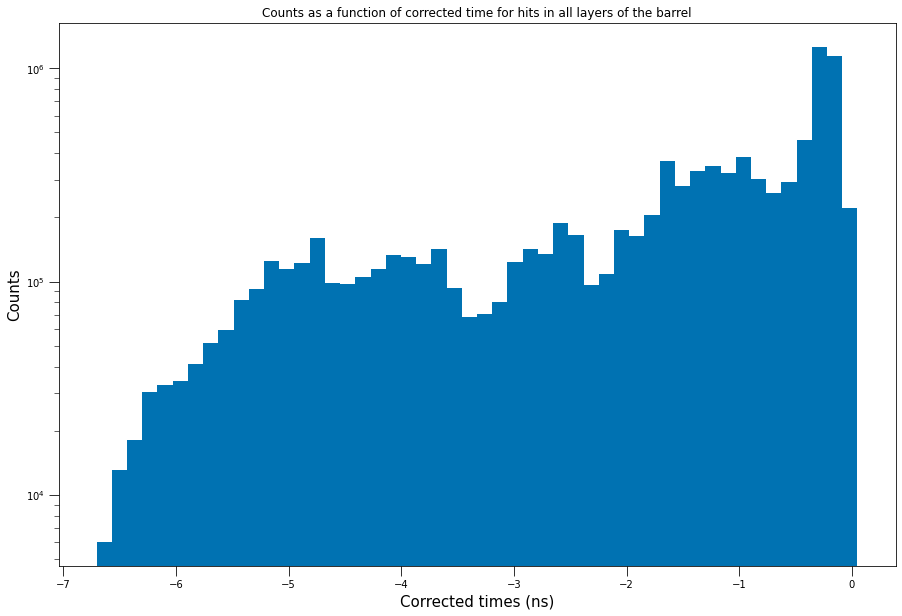

In [14]:
plot1DHistogram(correctedBarrelHits.t, bins=50, label="Counts as a function of corrected time for hits in all layers of the barrel;Corrected times (ns);Counts", scale="log")
#Histogram of corrected barrel hit times

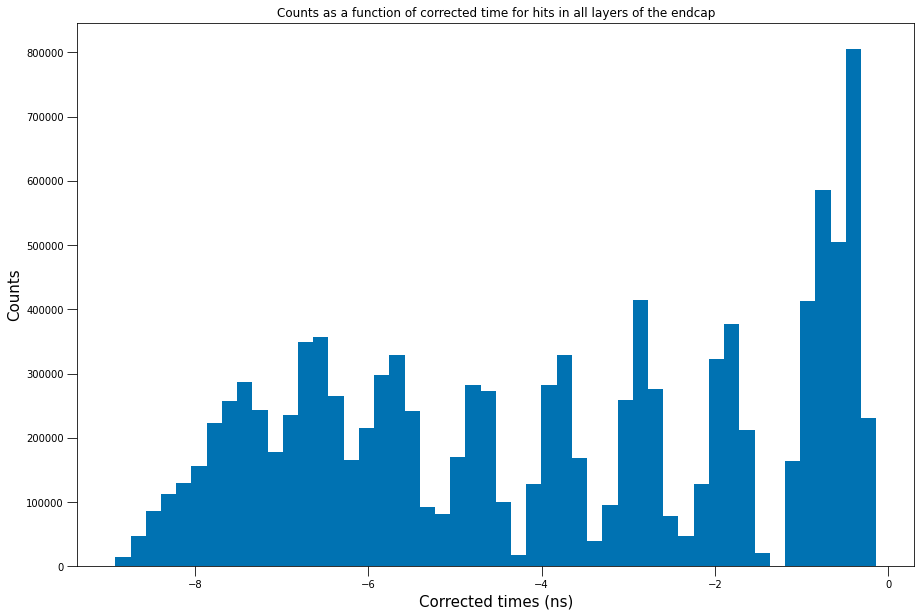

In [15]:
plot1DHistogram(correctedEndcapHits.t, bins=50, label="Counts as a function of corrected time for hits in all layers of the endcap;Corrected times (ns);Counts")
#Histogram of corrected endcap hit times

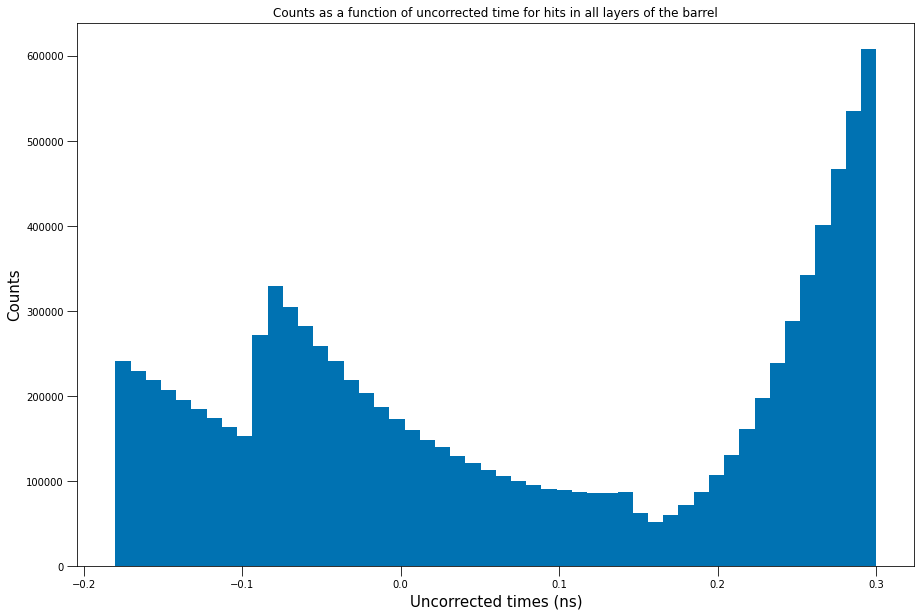

In [16]:
plot1DHistogram(barrelHits.t, bins=50, label="Counts as a function of uncorrected time for hits in all layers of the barrel;Uncorrected times (ns);Counts")
#Histogram of uncorrected barrel hit times

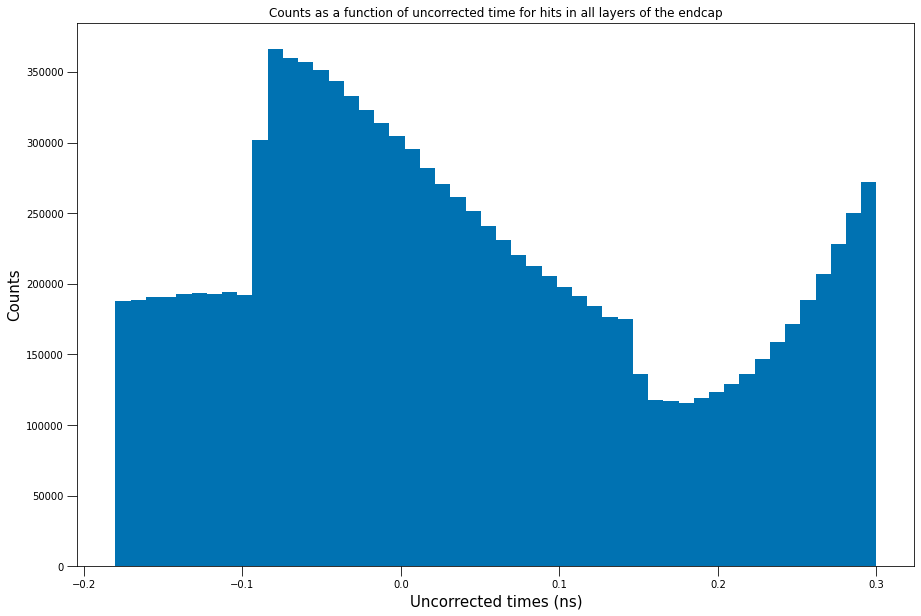

In [17]:
plot1DHistogram(endcapHits.t, bins=50, label="Counts as a function of uncorrected time for hits in all layers of the endcap;Uncorrected times (ns);Counts")
#Histogram of corrected barrel hit times

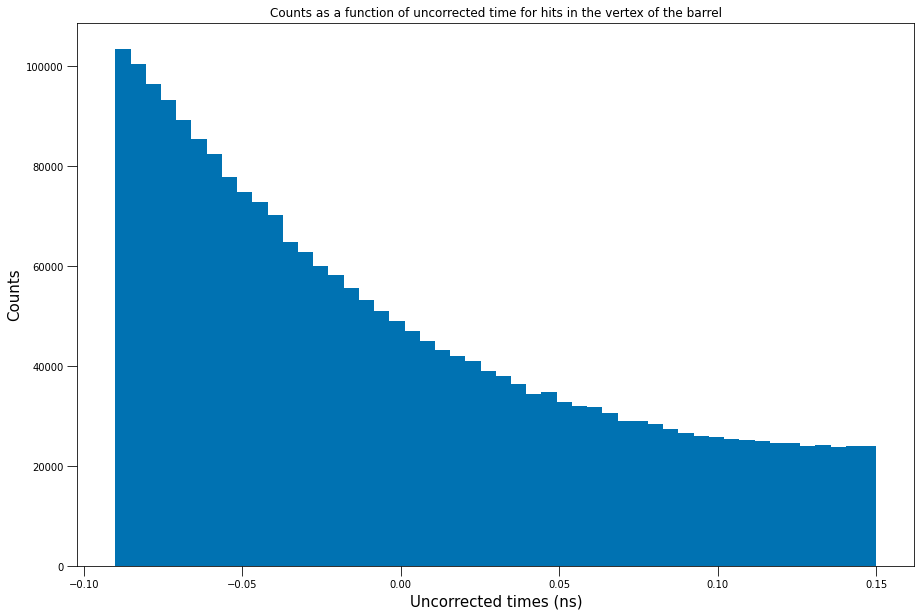

In [18]:
plot1DHistogram(locHits.VBT, bins=50, label="Counts as a function of uncorrected time for hits in the vertex of the barrel;Uncorrected times (ns);Counts")

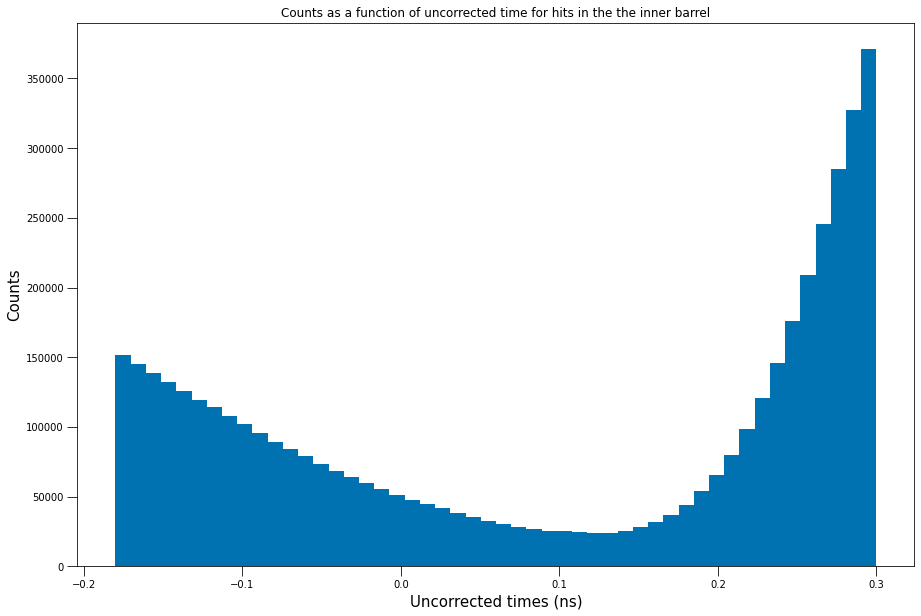

In [19]:
plot1DHistogram(locHits.IBT, bins=50, label="Counts as a function of uncorrected time for hits in the the inner barrel;Uncorrected times (ns);Counts")

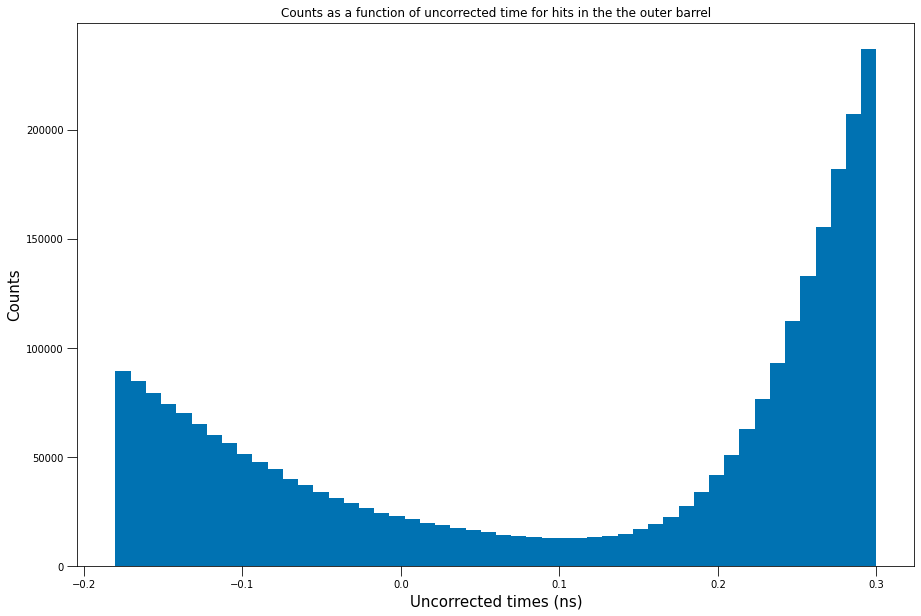

In [20]:
plot1DHistogram(locHits.OBT, bins=50, label="Counts as a function of uncorrected time for hits in the the outer barrel;Uncorrected times (ns);Counts")

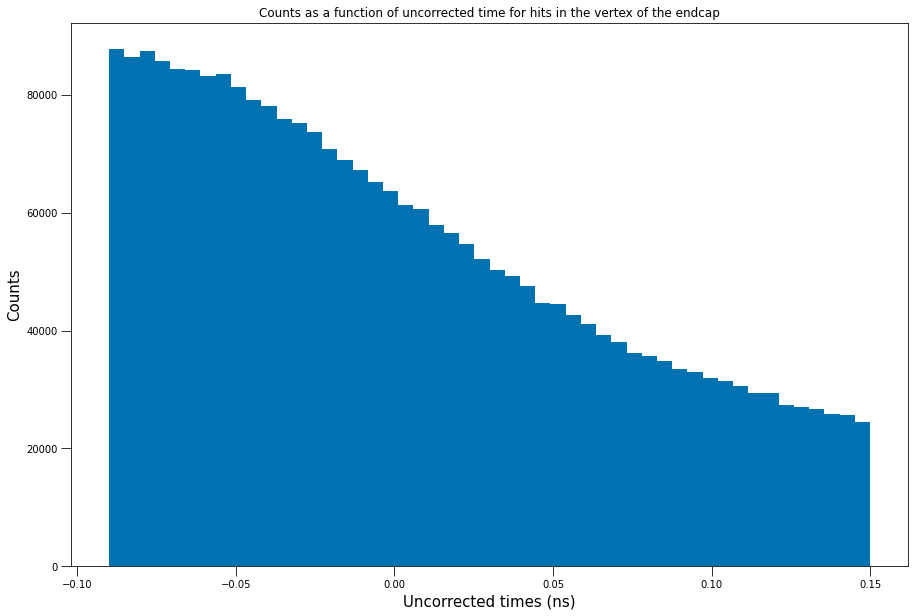

In [21]:
plot1DHistogram(locHits.VET, bins=50, label="Counts as a function of uncorrected time for hits in the vertex of the endcap;Uncorrected times (ns);Counts")

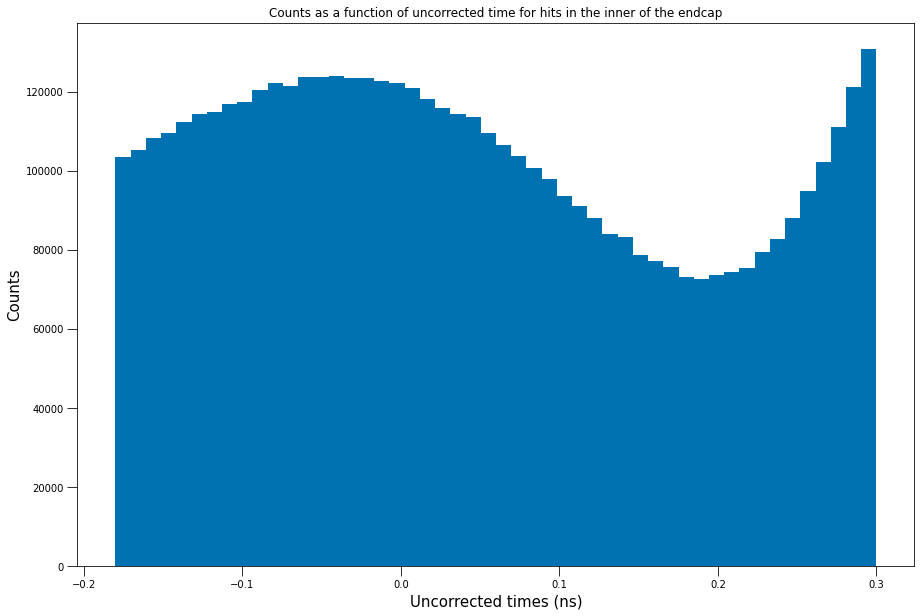

In [22]:
plot1DHistogram(locHits.IET, bins=50, label="Counts as a function of uncorrected time for hits in the inner of the endcap;Uncorrected times (ns);Counts")

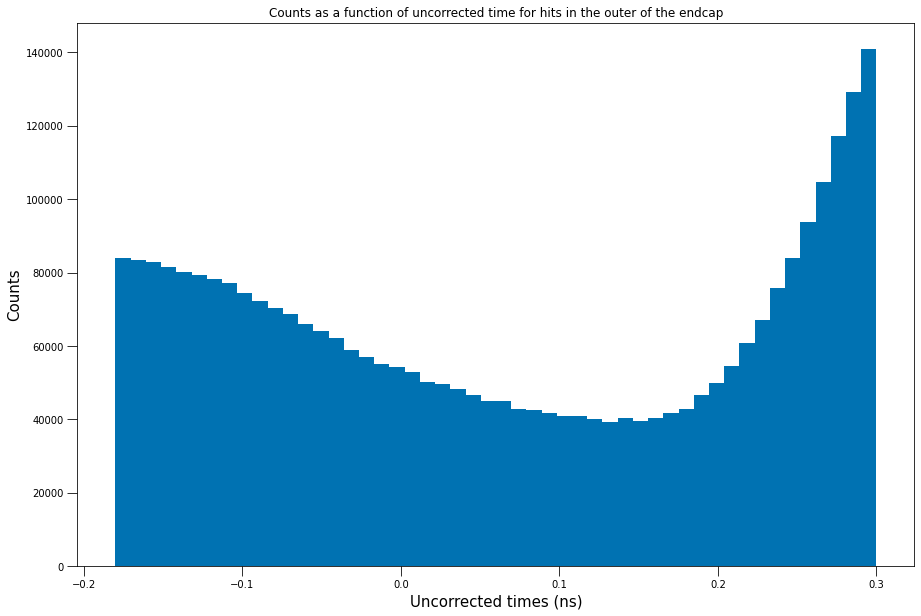

In [23]:
plot1DHistogram(locHits.OET, bins=50, label="Counts as a function of uncorrected time for hits in the outer of the endcap;Uncorrected times (ns);Counts")

### 2D Interactions between the corrected time and other parameters

In [24]:
vBarrelHits=vector.awk(barrelHits)
#vectoring barrel hits so I can automatically calculate things like phi

In [25]:
vEndcapHits=vector.awk(endcapHits)
#vectoring endcap hits so I can automatically calculate things like phi

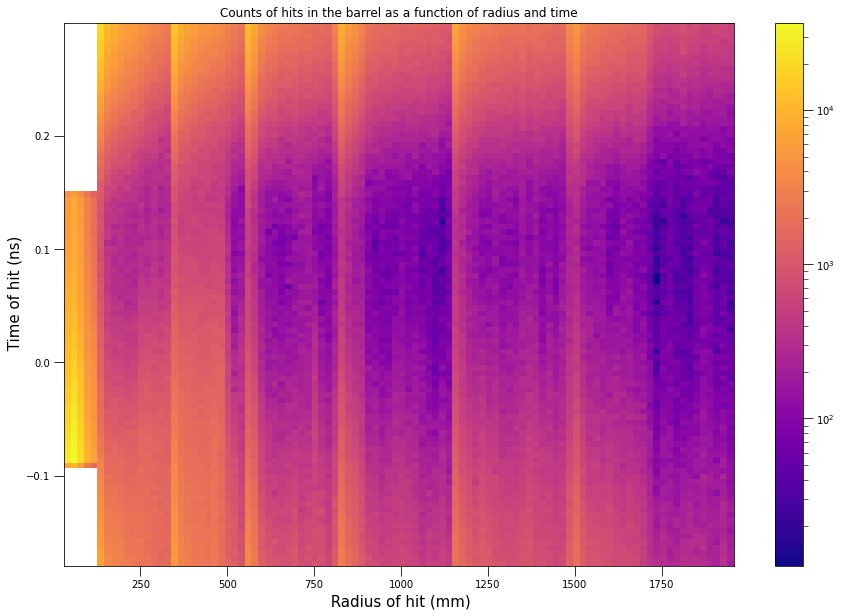

In [26]:
plot2DHistogram(np.sqrt(barrelHits.x**2+barrelHits.y**2 + barrelHits.z**2), barrelHits.t, bins=100, label="Counts of hits in the barrel as a function of radius and time; Radius of hit (mm); Time of hit (ns)")

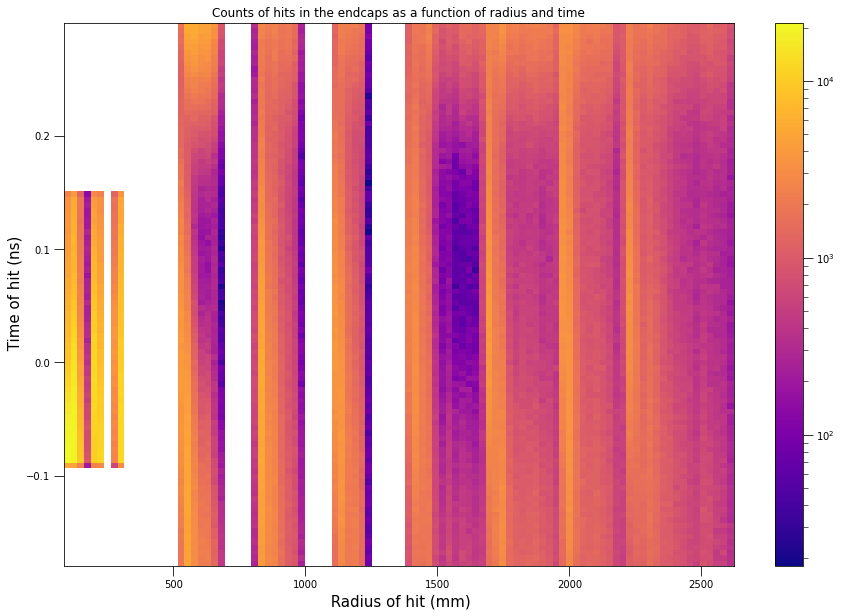

In [27]:
plot2DHistogram(np.sqrt(endcapHits.x**2+endcapHits.y**2 + endcapHits.z**2), endcapHits.t, bins=100, label="Counts of hits in the endcaps as a function of radius and time; Radius of hit (mm); Time of hit (ns)")

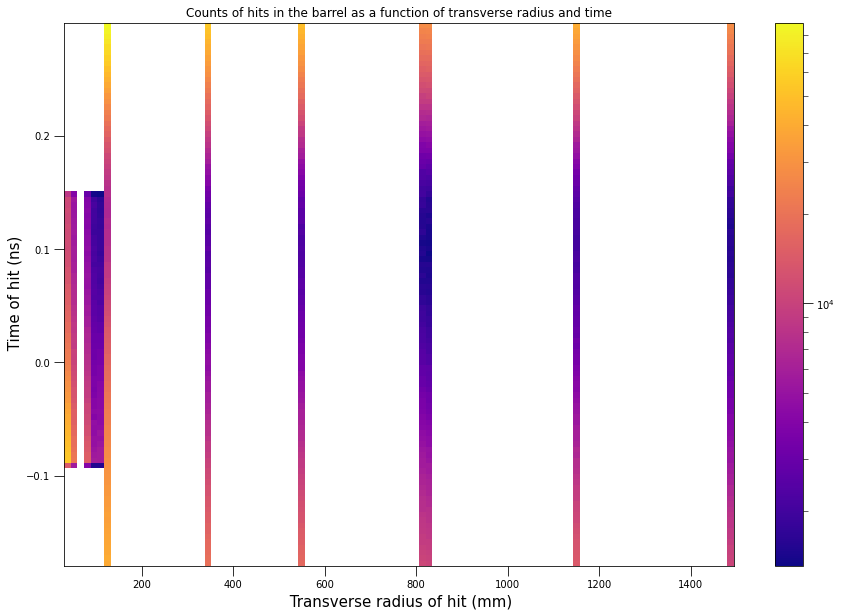

In [28]:
plot2DHistogram(np.sqrt(barrelHits.x**2+barrelHits.y**2), barrelHits.t, label="Counts of hits in the barrel as a function of transverse radius and time; Transverse radius of hit (mm); Time of hit (ns)")

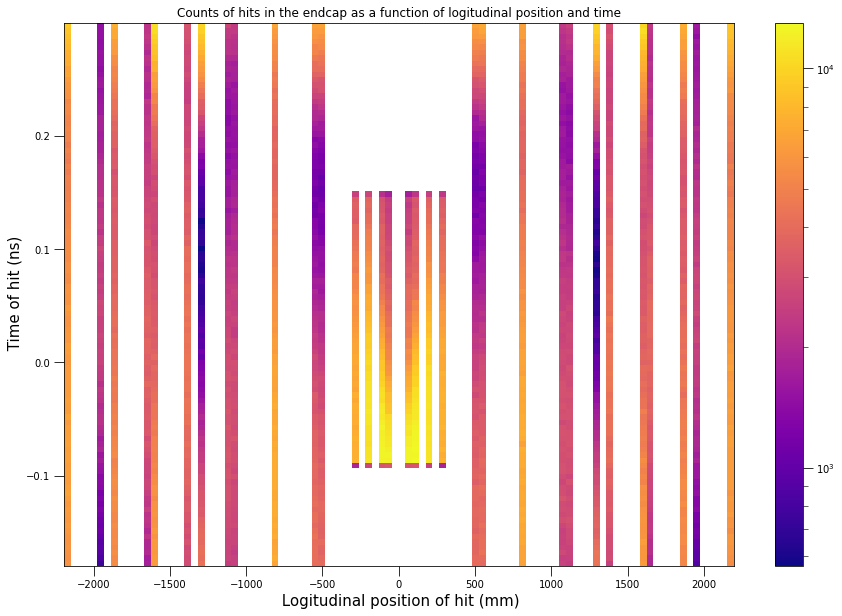

In [29]:
plot2DHistogram(endcapHits.z, endcapHits.t, label="Counts of hits in the endcap as a function of logitudinal position and time; Logitudinal position of hit (mm); Time of hit (ns)")

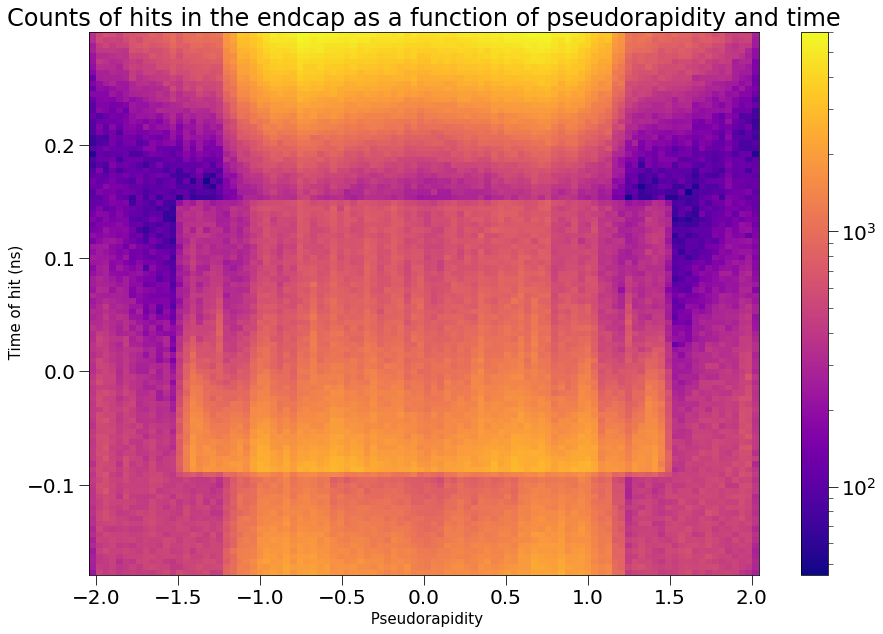

In [146]:
plot2DHistogram(vBarrelHits.eta, vBarrelHits.t, label="Counts of hits in the endcap as a function of pseudorapidity and time; Pseudorapidity; Time of hit (ns)")

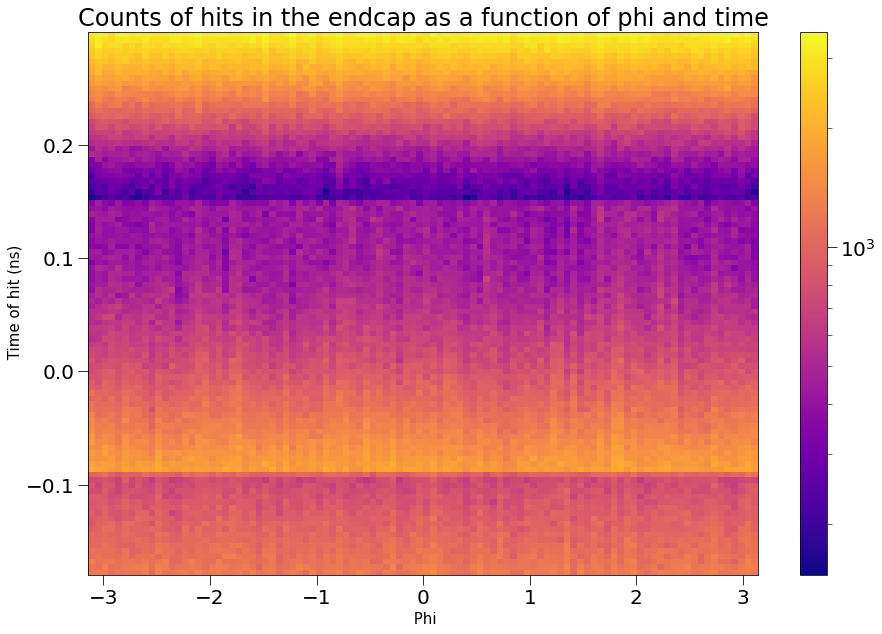

In [147]:
plot2DHistogram(vBarrelHits.phi, vBarrelHits.t, label="Counts of hits in the endcap as a function of phi and time; Phi; Time of hit (ns)")

### Investigation of energy vs time of hit

In [30]:
def PEtoV(P,E):
    #inputs are assumed to use c=1 to calculate P
    #calculated velocity from momentum and energy using relativistic equations
    c=299792458 #m/s
    return P*c/E
    #results are in m/s

In [31]:
def PMtoV(P,M):
    #inputs are assumed to use c=1 to calculate P and M
    #calculated velocity from momentum and mass using relativistic equations
    c=299792458 #m/s
    return c*P/np.sqrt(M**2+P**2)
    #results are in m/s

In [136]:
def MEtoV(M,E):
    #inputs are assumed to use c=1 to calculate M
    #calculated magnitude of velocity from mass and energy using relativistic equations
    c=299792458 #m/s
    return c*np.sqrt(1-M**2/E**2)
    #results are in m/s

In [137]:
#Calculating the magnitude of the velocity as a function of energy for a Muon
muon_mass=0.1056583755 #GeV/c^2
GeV_scale=np.linspace(0.001,1, 999) 
#Investigating the 0-1 GeV scale to see if there are any methods we can use to parse low energy hits
v_GeV=MEtoV(muon_mass, GEV_scale)

In [128]:
def delay(v,r):
    #Calculates the delay for a particle with velocity v to reach a distance r away compared to light
    #Takes in a 1d numpy array for v and r, outputs a 2d array
    c=299792458
    r=r.reshape(len(r),1)
    v=v.reshape(1,len(v))
    return np.matmul(r,(1/v-1/c))
    #output is a 2d array of every combination of v and r. The columns are different v, the rows are different r

In [139]:
silicon_r=np.linspace(20,1500,1480)/1000
#This is the range of radii for the silicoln tracks in the muon colider detector in meters

In [140]:
GeV_delay=delay(v_GeV, silicon_r)*10**9
#Converting to ns

Text(0, 0.5, 'Energy of muon (MeV)')

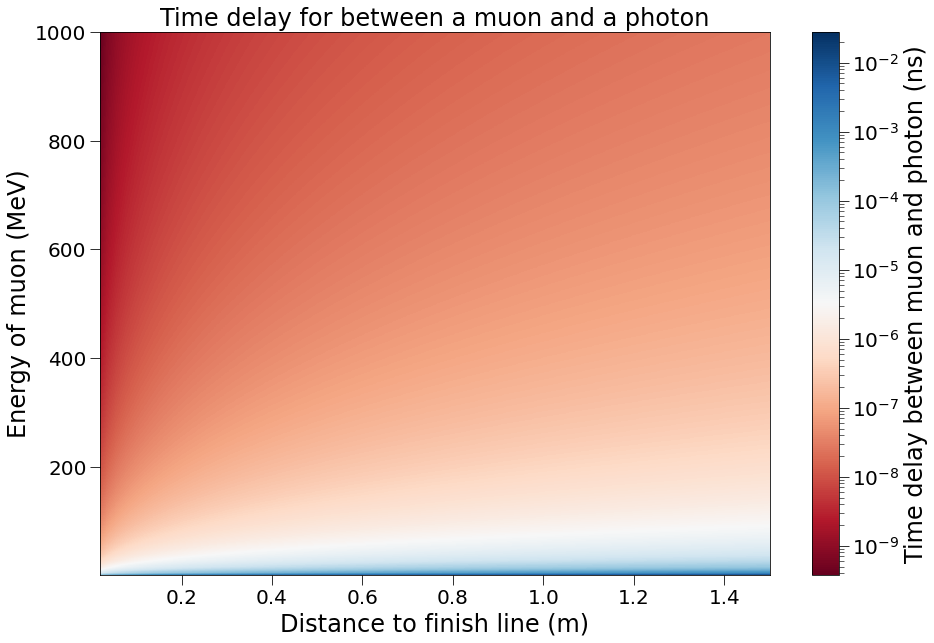

In [148]:
y, x = np.meshgrid(GeV_scale*1000,silicon_r)
z = GeV_delay[:-1, :-1]
z_min, z_max = -np.abs(-z).max(), 0.1

fig, ax = plt.subplots(figsize=(15,10))

c = ax.pcolormesh(x, y, z, norm=colors.LogNorm(vmin=z.min(), vmax=z.max()),cmap='RdBu')
ax.set_title('Time delay for between a muon and a photon')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax, label="Time delay between muon and photon (ns)")
ax.set_xlabel("Distance to finish line (m)")
ax.set_ylabel("Energy of muon (MeV)")